In [9]:
import pandas as pd 
import numpy as np
import math
import itertools
from itertools import compress
import geopandas as gpd
import pickle

import os
from glob import glob
from tqdm import tqdm
import dtw

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, fixed

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
import math

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
from minisom import MiniSom

import warnings
warnings.filterwarnings("ignore")

import sys
import os

sys.path.append('scripts')

In [22]:
idprov = '32'

# **Data dan Model Prep**

## Import Data

In [4]:
testing  = pd.read_pickle('../shared_ksa/04_Data_Preprocessing/training-test/32/training_imputation_32_VH_recode2.pkl')
cluster  = gpd.read_file('../shared_ksa/00_Data_Input/cluster_data/cluster_32_ok.gpkg')

In [6]:
testing['idkab'] = testing['idpoint'].str[:4]
testing = testing.merge(cluster[['idkab','cluster_data']], how='right', on='idkab')
testing = testing.loc[testing['observation']!='P']
testing = testing.dropna()

conditions = {
    'V1':1,
    'V2':2,
    'G':3,
    'H':4,
    'BP':0,
    'PL':5,
    'BPL':0,
    'NP':7,
    'NV':7
}

testing['observation2'] = testing['observation'].map(conditions)

testing.head()

,idpoint,idsubsegment,idsegment,nth,periode,observation,MGRS,VH_30,VH_29,VH_28,...,VH_4,VH_3,VH_2,VH_1,VH_0,year,date,idkab,cluster_data,observation2
0,320130009A1#01,320130009A1,320130009,1,2022_03,V2,48MXU,-16.274358,-16.490669,-14.767130,...,-20.859707,-18.526483,-16.742792,-15.056437,-15.399912,22,2022-01-01,3201,0,2
1,320130009A1#02,320130009A1,320130009,1,2022_03,V2,48MXU,-17.693644,-17.125240,-15.553412,...,-20.992794,-17.692861,-14.157176,-16.387884,-15.200477,22,2022-01-01,3201,0,2
2,320130009A1#03,320130009A1,320130009,1,2022_03,V2,48MXU,-16.638451,-15.987617,-15.562236,...,-21.520212,-19.001580,-16.142372,-17.775192,-16.659470,22,2022-01-01,3201,0,2
3,320130009A1#04,320130009A1,320130009,1,2022_03,V2,48MXU,-16.288292,-15.664023,-14.358597,...,-21.000000,-18.654710,-15.965685,-17.107149,-15.984833,22,2022-01-01,3201,0,2
4,320130009A1#05,320130009A1,320130009,1,2022_03,V2,48MXU,-16.522346,-15.086083,-15.482975,...,-20.279228,-18.585588,-16.662479,-16.971539,-15.644510,22,2022-01-01,3201,0,2


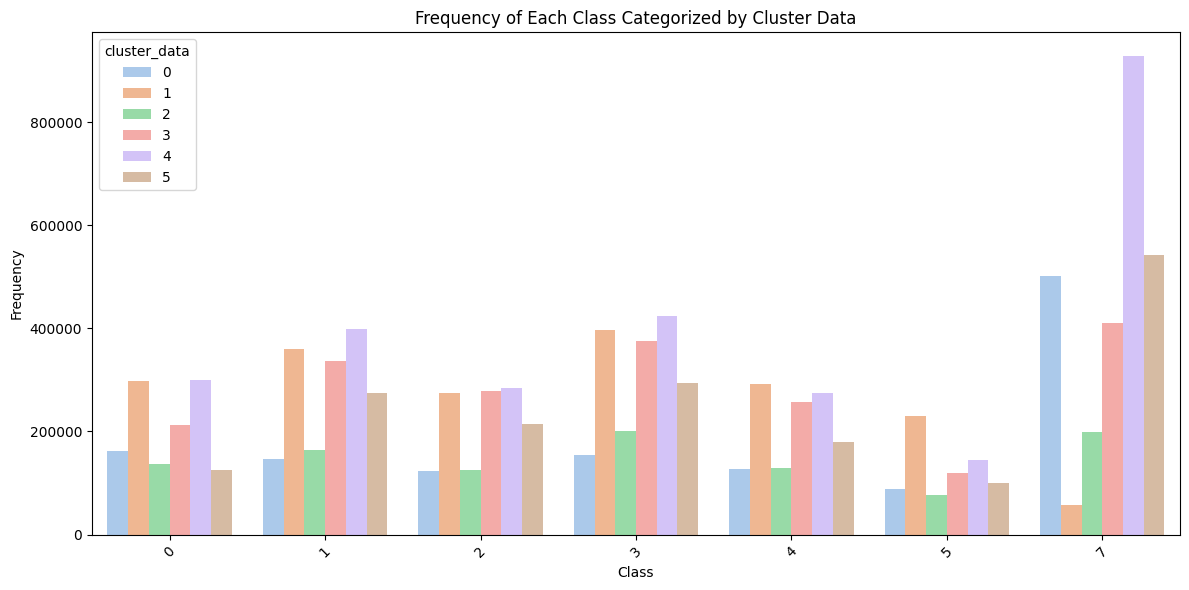

In [8]:
class_counts_clustered = testing.groupby(['observation2', 'cluster_data']).size().reset_index(name='counts')

plt.figure(figsize=(12, 6))
sns.barplot(data=class_counts_clustered, x='observation2', y='counts', hue='cluster_data', palette='pastel')

plt.title('Frequency of Each Class Categorized by Cluster Data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Import Model

In [1]:
filename = 'model_random_forest.pkl'
with open(filename, 'rb') as file:
    model_return_dict = pickle.load(file)

model_return_dict

{'cluster_0': RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1),
 'cluster_1': RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1),
 'cluster_2': RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1),
 'cluster_3': RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1),
 'cluster_4': RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1),
 'cluster_5': RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)}

# **Model Utilization (Prediction on Testing Data**

In [10]:
def model_utilization(data, Y_var, X_vars, iterasi, Category, model):
    db = pd.DataFrame()
    for idx in range(0,6):
        tpt = data.loc[data[iterasi]==idx]
        Y_pred = model[f"cluster_{idx}"].predict(tpt[X_vars])
        tpt['Y_pred'] = Y_pred
        tpt['observation'] = tpt[Y_var]
        db = pd.concat([db,tpt])
        
    list_district = list(db[Category].unique())
    result = []
    
    for i in list_district:
        temp = db.loc[db[Category] == i]
        res_temp = {}
        cm = confusion_matrix(temp['observation'].astype(str), temp['Y_pred'].astype(str))
        res_temp['district'] = i
        res_temp['accuracy'] = accuracy_score(temp['observation'].astype(str), temp['Y_pred'].astype(str))
        res_temp['precision'] = precision_score(temp['observation'].astype(str), temp['Y_pred'].astype(str), average='micro')
        res_temp['recall'] = recall_score(temp['observation'].astype(str), temp['Y_pred'].astype(str), average='micro')
        res_temp['f1_macro'] = f1_score(temp[Y_var].astype(str), temp['Y_pred'].astype(str), average='macro')
        res_temp['f1_micro'] = f1_score(temp[Y_var].astype(str), temp['Y_pred'].astype(str), average='micro')
        n = cm.shape[0]
        res_temp['racc_before'] = sum(cm[i, (i+1) % n] for i in range(n)) / cm.sum()
        res_temp['racc_after'] = sum(cm[(i+1) % n, i] for i in range(n)) / cm.sum()

        if '3' in temp.loc[:,Y_var].astype(str).unique():
            class_3_index = temp[Y_var].astype(str) == '3'
            res_temp['accuracy_class_3.0'] = accuracy_score(temp[Y_var][class_3_index], temp['Y_pred'][class_3_index])
        else:
            res_temp['accuracy_class_3.0'] = None   

        result.append(res_temp)
    
    result_df = pd.DataFrame(result)
    
    return db, result_df

In [16]:
import time
var_ = list(testing.loc[:,'VH_30':'VH_0'].columns.values) + ['nth']

start_time = time.time()

db, result_df = model_utilization(testing, 'observation2', var_, 'cluster_data', 'idkab', model_return_dict)

end_time = time.time()
processing_time = end_time - start_time
hours, rem = divmod(processing_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Processing time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:   19.0s remaining:    6.7s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:   19.8s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:   16.4s remaining:    5.7s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:   17.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    2.8s remaining:    1.0s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  74 out of 100 | elapsed:    8.7s remaining:    3.1s
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed:    9.9s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 co

Processing time: 0 hours, 19 minutes, 42.12 seconds


### Menampilkan Hasil Per Kabupaten/Kota

In [17]:
result_df['idkab'] = result_df['district']
result_df = result_df.merge(cluster[['idkab','cluster_data']], how='right', on='idkab')
result_df.to_csv('acc_pred.csv',index=False)

result_df

,district,accuracy,precision,recall,f1_macro,f1_micro,racc_before,racc_after,accuracy_class_3.0,idkab,cluster_data
0,3201,0.565862,0.565862,0.565862,0.454014,0.565862,0.105073,0.090873,0.414334,3201,0
1,3202,0.499939,0.499939,0.499939,0.422749,0.499939,0.108238,0.105997,0.307463,3202,4
2,3203,0.500998,0.500998,0.500998,0.472099,0.500998,0.108691,0.113335,0.392268,3203,4
3,3204,0.573347,0.573347,0.573347,0.507699,0.573347,0.099732,0.101147,0.428825,3204,5
4,3205,0.494900,0.494900,0.494900,0.438588,0.494900,0.120675,0.117408,0.413459,3205,4
5,3206,0.469475,0.469475,0.469475,0.420861,0.469475,0.082188,0.123750,0.371128,3206,3
6,3207,0.530234,0.530234,0.530234,0.517352,0.530234,0.099880,0.122252,0.444113,3207,3
7,3208,0.408480,0.408480,0.408480,0.382252,0.408480,0.111160,0.130080,0.317521,3208,3
8,3209,0.563078,0.563078,0.563078,0.547228,0.563078,0.110541,0.104098,0.451553,3209,2
9,3210,0.570436,0.570436,0.570436,0.563351,0.570436,0.119968,0.105711,0.486265,3210,2


In [18]:
cluster = cluster.merge(result_df[['idkab','accuracy']], on = 'idkab',how='outer')

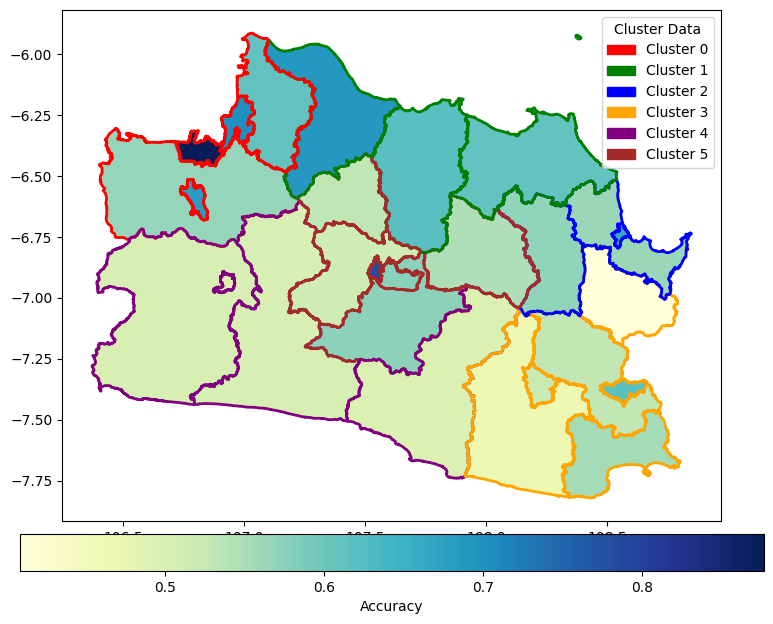

In [20]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

cluster_colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'orange', 4: 'purple', 5: 'brown'}

fig, ax = plt.subplots(figsize=(12, 8))

cluster.plot(column='accuracy', 
             legend=True, 
             cmap='YlGnBu',  
             ax=ax, 
             legend_kwds={'label': "Accuracy",
                          'orientation': "horizontal",
                          'shrink': 0.8,
                          'pad': 0.02})

cluster.boundary.plot(ax=ax, 
                      linewidth=2, 
                      color=cluster['cluster_data'].map(cluster_colors))

patches = [mpatches.Patch(color=cluster_colors[i], label=f'Cluster {i}') for i in range(6)]
ax.legend(handles=patches, loc='upper right', title="Cluster Data")

plt.show()

## Assess Prediction Each Cluster

In [21]:
db['id_periode'] = db['idsubsegment']+'#'+db['date'].astype(str)

pivot_table = pd.pivot_table(db, values='idpoint', index='id_periode', columns='Y_pred', aggfunc='count', fill_value=0)
pivot_table['dominant_class'] = pivot_table.idxmax(axis=1)
pivot_table = pivot_table.reset_index()
db = db.merge(pivot_table[['id_periode','dominant_class']], how='right', on='id_periode')

db['idx'] = db['idpoint'].str[-2:]
db_pred = db.loc[db['idx']=='13', ['idpoint', 'id_periode','observation','Y_pred','dominant_class', 'cluster_data', 'date']]

db_pred['date'] = db_pred['id_periode'].str[12:]
db_pred['idsubsegmen'] = db_pred['id_periode'].str[:11]
db_pred.head()

,idpoint,id_periode,observation,Y_pred,dominant_class,cluster_data,date,idsubsegmen
12,320101006A1#13,320101006A1#2022-01-01,2,1,2,0,2022-01-01,320101006A1
37,320101006A1#13,320101006A1#2022-02-01,2,2,2,0,2022-02-01,320101006A1
62,320101006A1#13,320101006A1#2022-03-01,3,4,4,0,2022-03-01,320101006A1
87,320101006A1#13,320101006A1#2022-04-01,4,0,0,0,2022-04-01,320101006A1
112,320101006A1#13,320101006A1#2022-05-01,0,0,0,0,2022-05-01,320101006A1


## Buat Kak Aldi

In [23]:
db_pred.to_csv(f'{idprov}_to_estimate_2 years.csv')

In [24]:
db_pred[['observation','Y_pred','dominant_class']] = db_pred[['observation','Y_pred','dominant_class']].astype(str)

### **Hasil Titik Tengah**

In [25]:
if not os.path.exists('image'):
    os.makedirs('image')

results = []

classes_1_4 = ['1', '2', '3', '4']

for cluster in db_pred['cluster_data'].unique():
    cluster_data = db_pred[db_pred['cluster_data'] == cluster]
    
    for date in cluster_data['date'].unique():
        date_data = cluster_data[cluster_data['date'] == date]
        
        pivot = pd.pivot_table(date_data, values='idpoint', index='observation', columns='dominant_class', aggfunc='count', fill_value=0)
        pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0) * 100
        labels = pivot.astype(str) + "\n" + pivot_percentage.round(2).astype(str) + "%"

        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_percentage, annot=labels, fmt='', cmap="RdBu", cbar_kws={'label': 'Percentage (%)'}, center=0)
        plt.title(f"Titik Tengah Subsegmen - Cluster {cluster} - Date {date}")
        plt.ylabel("True Labels")
        plt.xlabel("Predicted Labels")

        filename = f'image/heatmap_cluster_{cluster}_date_{date}.png'
        plt.savefig(filename, bbox_inches='tight')
        plt.close()

        correct_predictions = np.diag(pivot).sum()
        total_observations = pivot.values.sum()
        overall_accuracy = correct_predictions / total_observations

        if set(classes_1_4).issubset(pivot.index) and set(classes_1_4).issubset(pivot.columns):
            class_correct_1_4 = pivot.loc[classes_1_4, classes_1_4].values.diagonal().sum()
            class_total_1_4 = pivot.loc[classes_1_4].sum().sum()
            class_accuracy_1_4 = class_correct_1_4 / class_total_1_4
        else:
            class_accuracy_1_4 = np.nan
            
        class_accuracies = {}
        for cls in classes_1_4 + ['0', '5', '7']:
            if cls in pivot.index and cls in pivot.columns:
                class_correct_single = pivot.loc[cls, cls]
                class_total_single = pivot.loc[cls].sum()
                class_accuracy = class_correct_single / class_total_single if class_total_single > 0 else np.nan
            else:
                class_accuracy = np.nan
            class_accuracies[cls] = class_accuracy

        result = {
            'Cluster': cluster,
            'Date': date,
            'Overall Accuracy': overall_accuracy,
            'Accuracy (1, 2, 3, 4)': class_accuracy_1_4,
            'Accuracy Class 0': class_accuracies['0'],
            'Accuracy Class 1': class_accuracies['1'],
            'Accuracy Class 2': class_accuracies['2'],
            'Accuracy Class 3': class_accuracies['3'],
            'Accuracy Class 4': class_accuracies['4'],
            'Accuracy Class 5': class_accuracies['5'],
            'Accuracy Class 7': class_accuracies['7']
        }

        results.append(result)

accuracy_df = pd.DataFrame(results)

In [26]:
accuracy_df.head()

,Cluster,Date,Overall Accuracy,"Accuracy (1, 2, 3, 4)",Accuracy Class 0,Accuracy Class 1,Accuracy Class 2,Accuracy Class 3,Accuracy Class 4,Accuracy Class 5,Accuracy Class 7
0,0,2022-01-01,0.686204,0.562879,0.289720,0.529880,0.652985,0.593361,0.400685,0.700000,0.906623
1,0,2022-02-01,0.710243,0.629967,0.316129,0.686441,0.477679,0.710702,0.446667,0.575893,0.914317
2,0,2022-03-01,0.719727,0.628326,0.330357,0.781065,0.567839,0.527675,0.602128,0.600000,0.918390
3,0,2022-04-01,0.687198,0.589580,0.576923,0.663818,0.559322,0.716216,0.389381,0.519084,0.867535
4,0,2022-05-01,0.676683,0.604801,0.611486,0.625532,0.466942,0.635678,0.682692,0.381720,0.839957


In [27]:
accuracy_df.to_csv('acc_res_pred.csv')

## **Monthly Accuracy**

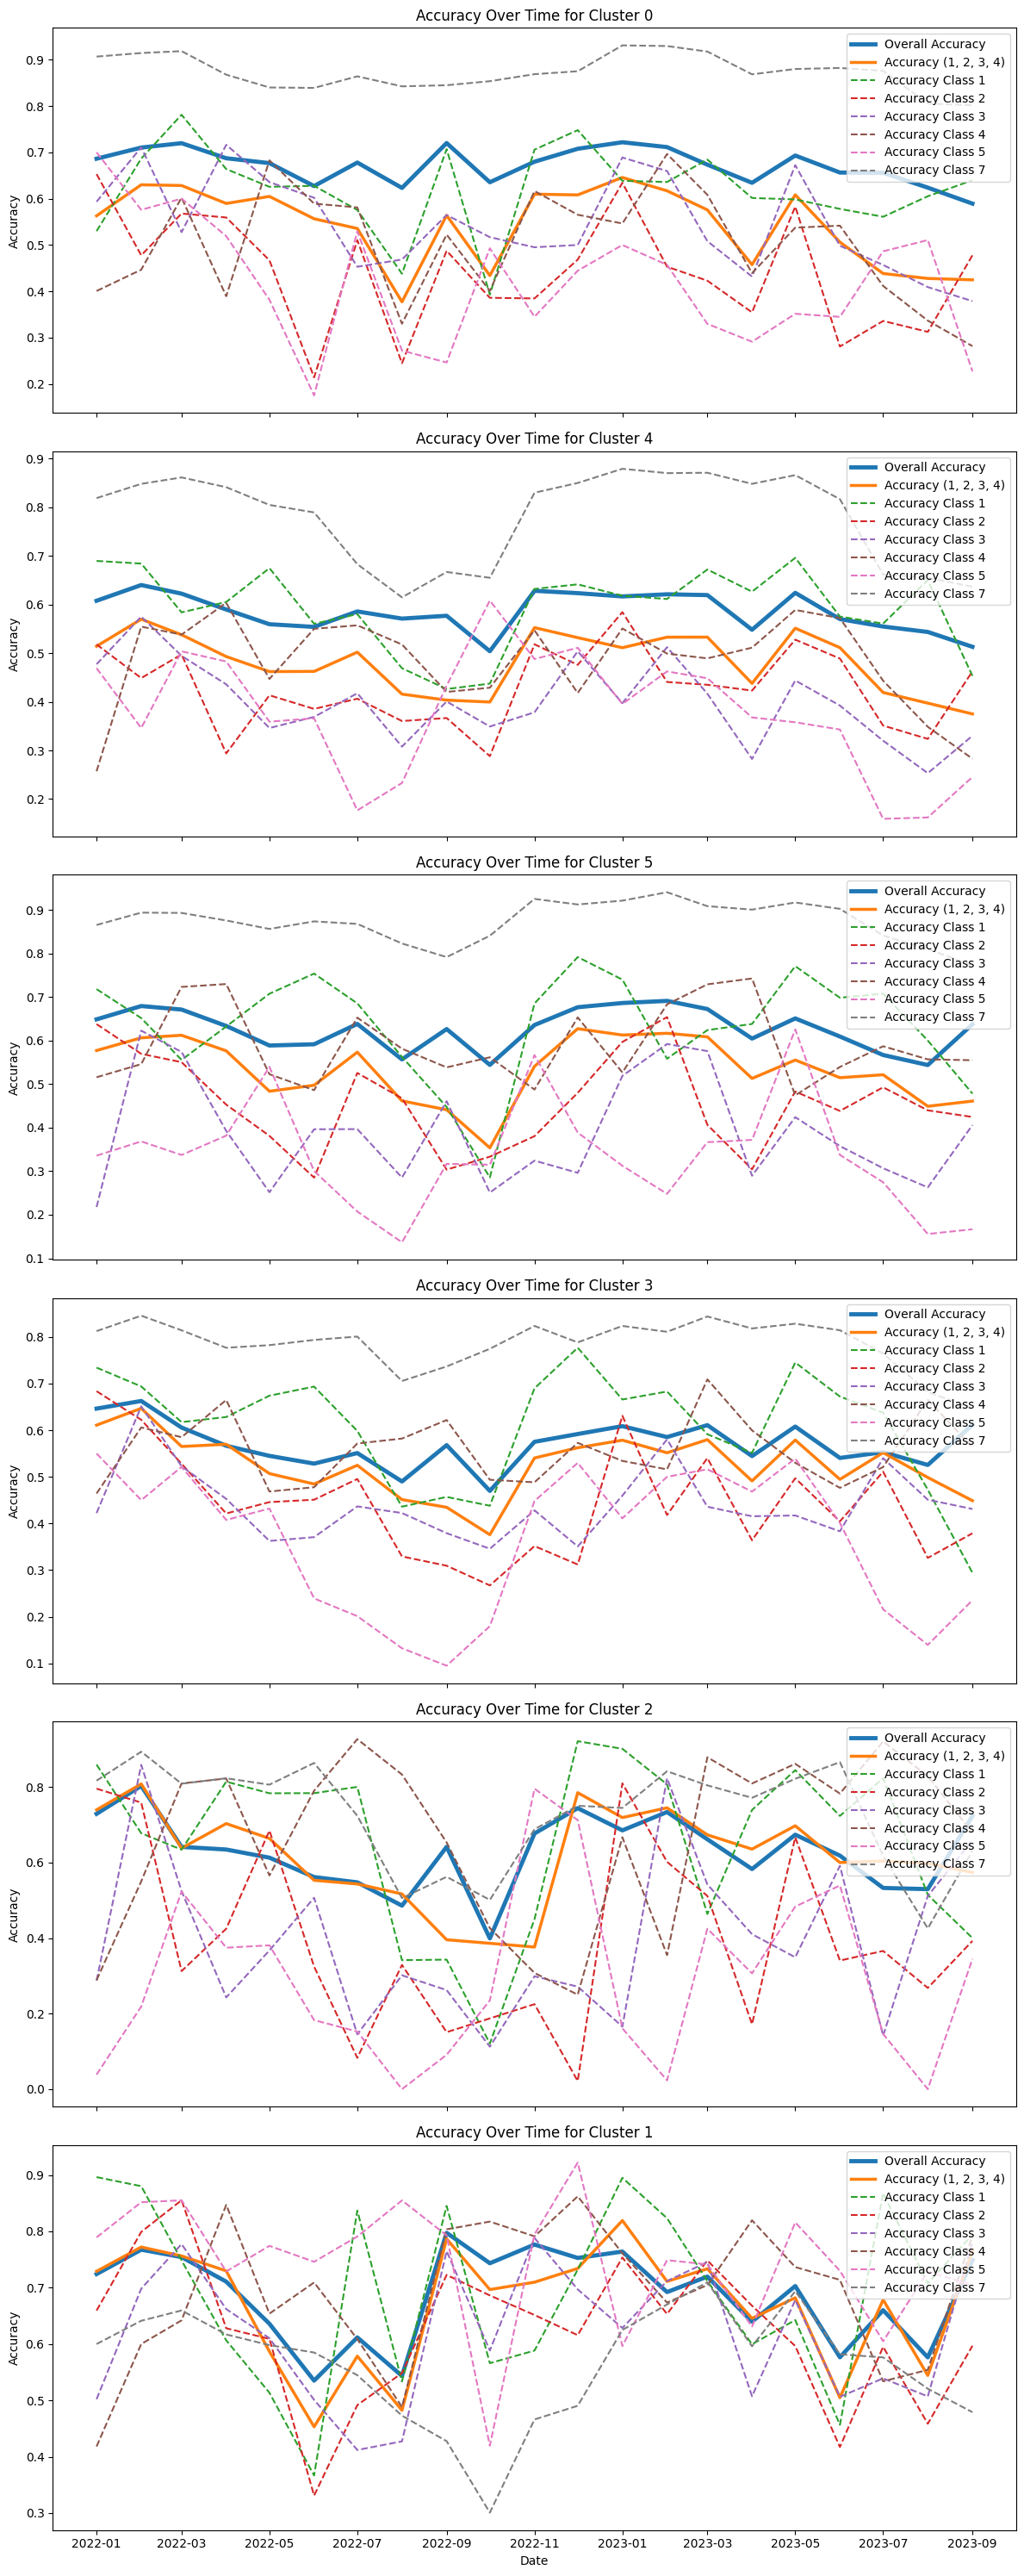

In [28]:
accuracy_metrics = ['Overall Accuracy', 'Accuracy (1, 2, 3, 4)', 
                    'Accuracy Class 1', 'Accuracy Class 2', 
                    'Accuracy Class 3', 'Accuracy Class 4', 
                    'Accuracy Class 5', 'Accuracy Class 7']

accuracy_df['Date'] = pd.to_datetime(accuracy_df['Date'])
clusters = accuracy_df['Cluster'].unique()


fig, axes = plt.subplots(len(clusters), 1, figsize=(12, len(clusters) * 5), sharex=True)

for i, cluster in enumerate(clusters):
    cluster_data = accuracy_df[accuracy_df['Cluster'] == cluster]
    
    for metric in accuracy_metrics:
        if metric == 'Overall Accuracy':
            sns.lineplot(data=cluster_data, x='Date', y=metric, ax=axes[i], label=metric, linewidth=3.5)
        elif metric == 'Accuracy (1, 2, 3, 4)':
            sns.lineplot(data=cluster_data, x='Date', y=metric, ax=axes[i], label=metric, linewidth=2.5)
        else:
            sns.lineplot(data=cluster_data, x='Date', y=metric, ax=axes[i], label=metric, linewidth=1.5, linestyle='--')
 
    axes[i].set_title(f"Accuracy Over Time for Cluster {cluster}")
    axes[i].set_ylabel('Accuracy')
    axes[i].legend(loc='upper right')

plt.xlabel('Date')
plt.tight_layout()
plt.show()
